# Where's Waldo?

Importing the data

In [2]:
!pip install kagglehub

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("residentmario/wheres-waldo")

print("Path to dataset files:", path)

/Users/laurenbeede/miniconda3/envs/sp25/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/laurenbeede/.cache/kagglehub/datasets/residentmario/wheres-waldo/versions/2


## Testing the images of Waldo

In [4]:
import matplotlib.pyplot as plt
import os
datapath = path+'/wheres-waldo/Hey-Waldo'

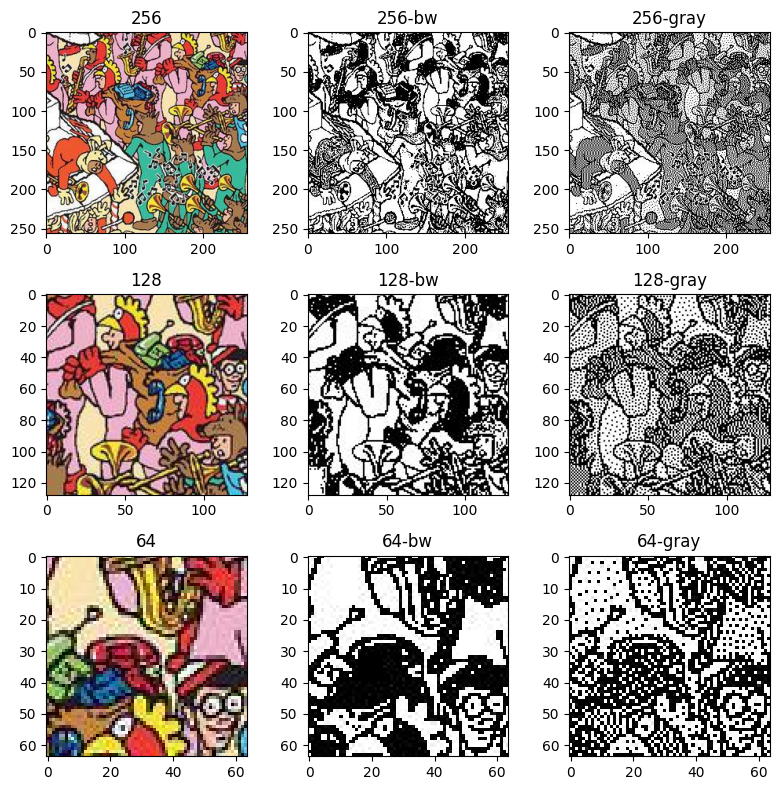

In [5]:
fig, axarr = plt.subplots(3, 3, figsize=(8, 8))

im = plt.imread(datapath+"/256/waldo/10_3_1.jpg")
axarr[0][0].imshow(im)
axarr[0][0].set_title("256")

im = plt.imread(datapath+"/256-bw/waldo/10_3_1.jpg")
axarr[0][1].imshow(im)
axarr[0][1].set_title("256-bw")

im = plt.imread(datapath+"/256-gray/waldo/10_3_1.jpg")
axarr[0][2].imshow(im)
axarr[0][2].set_title("256-gray")

im = plt.imread(datapath+"/128/waldo/10_7_2.jpg")
axarr[1][0].imshow(im)
axarr[1][0].set_title("128")

im = plt.imread(datapath+"/128-bw/waldo/10_7_2.jpg")
axarr[1][1].imshow(im)
axarr[1][1].set_title("128-bw")

im = plt.imread(datapath+"/128-gray/waldo/10_7_2.jpg")
axarr[1][2].imshow(im)
axarr[1][2].set_title("128-gray")

im = plt.imread(datapath+"/64/waldo/10_15_4.jpg")
axarr[2][0].imshow(im)
axarr[2][0].set_title("64")

im = plt.imread(datapath+"/64-bw/waldo/10_15_4.jpg")
axarr[2][1].imshow(im)
axarr[2][1].set_title("64-bw")

im = plt.imread(datapath+"/64-gray/waldo/10_15_4.jpg")
axarr[2][2].imshow(im)
axarr[2][2].set_title("64-gray")

plt.tight_layout()

Problems include:  
- Waldo as differs in size
- Many more not-waldo images than waldo images
- Waldo can be obstructed

## Object detecting

Installing dependencies

In [6]:
!pip install torch
!pip install torchvision
!pip install imutils
!pip install matplotlib
!pip install numpy
!pip install tqdm

  Using cached torch-2.4.1-cp38-none-macosx_11_0_arm64.whl.metadata (26 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 5.5 MB/s eta 0:00:0000:0100:01
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.2 MB/s eta 0:00:00a 0:00:010m
  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=ef05beffba32a69a3f292d5714d44f0531f0c3bf64e5fd2dfa6c1e74fe0a3bb3
  Stored in directory: /Users/laurenbeede/Library/Caches/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


In [7]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn ## Pre-trained model from PyTorch
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [8]:
numnotwaldo = len(os.listdir(datapath+'/128/notwaldo/'))
numwaldo = len(os.listdir(datapath+'/128/waldo/'))

In [9]:
print(f"There are {numwaldo} images of Waldo")
print(f"There are {numnotwaldo} images of not Waldo")

There are 27 images of Waldo
There are 1317 images of not Waldo


In [ ]:
import config
import custom_tensor_dataset

In [14]:
# import the necessary packages
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
class ObjectDetector(Module):
  def __init__(self, baseModel, numClasses):
    super(ObjectDetector, self).__init__()
    # initialize the base model and the number of classes
    self.baseModel = baseModel
    self.numClasses = numClasses
    # build the regressor head for outputting the bounding box
    # coordinates
    self.regressor = Sequential(
      Linear(baseModel.fc.in_features, 128),
      ReLU(),
      Linear(128, 64),
      ReLU(),
      Linear(64, 32),
      ReLU(),
      Linear(32, 4),
      Sigmoid()
    )
    # build the classifier head to predict the class labels
    self.classifier = Sequential(
      Linear(baseModel.fc.in_features, 512),
      ReLU(),
      Dropout(),
      Linear(512, 512),
      ReLU(),
      Dropout(),
      Linear(512, self.numClasses)
    )
    # set the classifier of our base model to produce outputs
    # from the last convolution block
    self.baseModel.fc = Identity()

  def forward(self, x):
    # pass the inputs through the base model and then obtain
    # predictions from two different branches of the network
    features = self.baseModel(x)
    bboxes = self.regressor(features)
    classLogits = self.classifier(features)
    # return the outputs as a tuple
    return (bboxes, classLogits)

In [15]:
# import the necessary packages

from pyimagesearch import config
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import cv2
import os
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

ModuleNotFoundError: No module named 'pyimagesearch'